In [1]:
#Importing packages
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## LOADING THE PRICE DATA

In [2]:
#Defining the stock --> MSFT = Microsoft, .INX = S&P500
msft = yf.Ticker("MSFT")

In [3]:
#Stock information
msft.info

{'zip': '98052-6399',
 'sector': 'Technology',
 'fullTimeEmployees': 181000,
 'longBusinessSummary': 'Microsoft Corporation develops, licenses, and supports software, services, devices, and solutions worldwide. Its Productivity and Business Processes segment offers Office, Exchange, SharePoint, Microsoft Teams, Office 365 Security and Compliance, and Skype for Business, as well as related Client Access Licenses (CAL); Skype, Outlook.com, OneDrive, and LinkedIn; and Dynamics 365, a set of cloud-based and on-premises business solutions for organizations and enterprise divisions. Its Intelligent Cloud segment licenses SQL, Windows Servers, Visual Studio, System Center, and related CALs; GitHub that provides a collaboration platform and code hosting service for developers; and Azure, a cloud platform. It also offers support services and Microsoft consulting services to assist customers in developing, deploying, and managing Microsoft server and desktop solutions; and training and certifica

In [4]:
#Importing the historic price action
#hist = msft.history(period="max", interval="1wk")
hist = msft.history(period="max", interval="1d")
#hist = msft.history(period="2y", interval="1h")
#hist = msft.history(period="2y", interval="15m")
#hist = msft.history(period="2y", interval="5m")

In [5]:
#Visualising the data
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.055783,0.063987,0.055783,0.061252,1031788800,0.0,0.0
1986-03-14,0.061252,0.064533,0.061252,0.063439,308160000,0.0,0.0
1986-03-17,0.063439,0.065080,0.063439,0.064533,133171200,0.0,0.0
1986-03-18,0.064533,0.065080,0.062345,0.062892,67766400,0.0,0.0
1986-03-19,0.062892,0.063439,0.061252,0.061799,47894400,0.0,0.0
...,...,...,...,...,...,...,...
2022-04-08,300.440002,301.119995,296.279999,296.970001,24347400,0.0,0.0
2022-04-11,291.790009,292.609985,285.000000,285.260010,34569300,0.0,0.0
2022-04-12,289.239990,290.739990,280.489990,282.059998,30966700,0.0,0.0


In [6]:
#Formatting and slicing the data to contain OHLC and Volume
data = np.array(hist, dtype = float)
data = data[:,:5]

Text(0, 0.5, 'Price ($)')

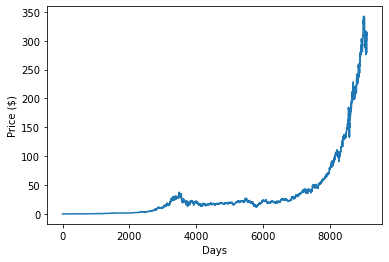

In [7]:
#Plotting the historical close prices
plt.plot(data[:,3])
plt.xlabel("Days")
plt.ylabel("Price ($)")

---

## DEFINING THE INDICATORS

In [8]:
#Moving Average function (MA)

def MA(dataset, timeframe_MA):

    Moving_Average = np.zeros(len(dataset))
    Moving_Average[:timeframe_MA-1] = "NaN"
    
    for i in range(timeframe_MA-1, len(dataset)):
        Moving_Average[i] = np.mean(dataset[i-timeframe_MA+1:i+1])
        
    return Moving_Average

In [9]:
#Exponential Moving Average function (EMA)

def EMA(dataset, MA, timeframe_EMA):

    Exponential_Moving_Average = np.zeros(len(dataset))
    Exponential_Moving_Average[:timeframe_EMA-1] = "NaN"
    Exponential_Moving_Average[timeframe_EMA-1] = MA[timeframe_EMA-1]
    
    multiplier = 2/(timeframe_EMA+1)
    
    for i in range(timeframe_EMA, len(dataset)):
        Exponential_Moving_Average[i] = (dataset[i] * multiplier) + (Exponential_Moving_Average[i-1] * (1-multiplier))
        
    return Exponential_Moving_Average

In [10]:
#Relative Strength Index function (RSI)

def RSI(dataset, timeframe_RSI):
    
    RSI = np.zeros(len(dataset))
    RSI[:timeframe_RSI] = "NaN"
    
    #for i in timeframe_RSI:
        
    gain = np.zeros(timeframe_RSI)
    loss = np.zeros(timeframe_RSI)
        
    for j in range(1, timeframe_RSI+1):
            
        if dataset[j] > dataset[j-1]:
            gain[j-1] = dataset[j] - dataset[j-1]
        elif dataset[j] < dataset[j-1]:
            loss[j-1] = dataset[j-1] - dataset[j]
            
    avg_gain = sum(gain) / timeframe_RSI
    avg_loss = sum(loss) / timeframe_RSI
    RS = avg_gain / avg_loss
    RSI[timeframe_RSI] = 100 - (100/(1+RS))
    
    for i in range(timeframe_RSI+1, len(dataset)):
        
        if dataset[i] > dataset[i-1]:
            
            avg_gain = (avg_gain*(timeframe_RSI-1)+(dataset[i] - dataset[i-1])) / timeframe_RSI
            avg_loss = (avg_loss*(timeframe_RSI-1)) / timeframe_RSI
            RS = avg_gain / avg_loss
            RSI[i] = 100 - (100/(1+RS))
            
        elif dataset[i] < dataset[i-1]:
            
            avg_gain = (avg_gain*(timeframe_RSI-1)) / timeframe_RSI
            avg_loss = (avg_loss*(timeframe_RSI-1)+(dataset[i-1] - dataset[i])) / timeframe_RSI
            RS = avg_gain / avg_loss
            RSI[i] = 100 - (100/(1+RS))
        
        else:
            
            avg_gain = (avg_gain*(timeframe_RSI-1)) / timeframe_RSI
            avg_loss = (avg_loss*(timeframe_RSI-1)) / timeframe_RSI
            RS = avg_gain / avg_loss
            RSI[i] = 100 - (100/(1+RS))
    
    return RSI

In [11]:
#Stochastic Relative Strength Index function (Stochastic RSI)

def STOCH_RSI(dataset, timeframe_RSI, timeframe_K, timeframe_D):
    
    RSI_NEEDED = RSI(dataset, timeframe_RSI)
    
    STOCH_RSI_K = np.zeros(len(dataset))
    STOCH_RSI_D = np.zeros(len(dataset))
    
    STOCH_RSI_K[:timeframe_RSI+timeframe_K] = "NaN"
    STOCH_RSI_D[:timeframe_RSI+timeframe_K+timeframe_D] = "NaN"
    
    for i in range(timeframe_RSI+timeframe_K, len(dataset)):
        
        STOCH_RSI_K[i] = 100 * (RSI_NEEDED[i] - (min(RSI_NEEDED[i-timeframe_K+1:i+1]))) / ((max(RSI_NEEDED[i-timeframe_K+1:i+1])) - (min(RSI_NEEDED[i-timeframe_K+1:i+1])))
    
    STOCH_RSI_D[timeframe_RSI:] = MA(STOCH_RSI_K[timeframe_RSI:], timeframe_D)
    
    return STOCH_RSI_K, STOCH_RSI_D

In [12]:
#Moving Average Convergence Divergence function (MACD)

def MACD(dataset, timeframe_1_MACD, timeframe_2_MACD, timeframe_3_MACD):

    MACD_Value = np.zeros(len(dataset))
    Signal_Line = np.zeros(len(dataset))
    MACD_Histogram = np.zeros(len(dataset))
    
    MACD_Value[:timeframe_2_MACD] = "NaN"
    Signal_Line[:timeframe_2_MACD+timeframe_3_MACD] = "NaN"
    MACD_Histogram[:timeframe_2_MACD+timeframe_3_MACD] = "NaN"
    
    MA_12 = MA(dataset, timeframe_1_MACD)
    MA_26 = MA(dataset, timeframe_2_MACD)
    
    EMA_12 = EMA(dataset, MA_12, timeframe_1_MACD)
    EMA_26 = EMA(dataset, MA_26, timeframe_2_MACD)
    
    
    MACD_Value[timeframe_2_MACD:] = EMA_12[timeframe_2_MACD:] - EMA_26[timeframe_2_MACD:]
    
    Signal_Line[timeframe_2_MACD:] = MA(MACD_Value[timeframe_2_MACD:], timeframe_3_MACD)
    
    MACD_Histogram = MACD_Value - Signal_Line
        
    return MACD_Value, Signal_Line, MACD_Histogram

In [13]:
#Bollinger Bands (BB)

def BB(dataset, timeframe_BB, BB_Std):

    BB_UP = np.zeros(len(dataset))
    BB_DOWN = np.zeros(len(dataset))
    
    BB_UP[:timeframe_BB-1] = "NaN"
    BB_DOWN[:timeframe_BB-1] = "NaN"
    
    MA_20 = MA(dataset, timeframe_BB)
    
    for i in range(timeframe_BB-1, len(dataset)):
        BB_UP[i] = MA_20[i] + 2*(np.std(dataset[i-timeframe_BB+1:i+1]))
        BB_DOWN[i] = MA_20[i] - 2*(np.std(dataset[i-timeframe_BB+1:i+1]))
        
    return BB_UP, MA_20, BB_DOWN

In [14]:
#Average Directional Movement Index (ADX)

def ADX(dataset_OHLC, timeframe_ADX):
    
    #Calculating TR
    M1 = np.zeros(len(dataset_OHLC[:,0]))
    M2 = np.zeros(len(dataset_OHLC[:,0]))
    M3 = np.zeros(len(dataset_OHLC[:,0]))
    M2[0] = "NaN"
    M3[0] = "NaN"
    
    M1 = dataset_OHLC[:,1] - dataset_OHLC[:,2]
    for i in range(1,len(dataset_OHLC[:,0])):
        M2[i] = abs(dataset_OHLC[i,1] - dataset_OHLC[i-1,3])
        M3[i] = abs(dataset_OHLC[i,2] - dataset_OHLC[i-1,3])
        
    TR = np.zeros(len(dataset_OHLC[:,0]))
    TR[0] = "NaN"
    for i in range(1,len(dataset_OHLC[:,0])):
        TR[i] = max(M1[i],M2[i],M3[i])
    
    #Calculating ATR
    ATR = np.zeros(len(dataset_OHLC[:,0]))
    ATR[:timeframe_ADX] = "NaN"
    ATR[timeframe_ADX] = np.mean(TR[1:timeframe_ADX])
    for i in range(timeframe_ADX+1,len(dataset_OHLC[:,0])):
        ATR[i] = ((ATR[i-1]*(timeframe_ADX-1))+TR[i])/timeframe_ADX
    
    #Calculating +DX and -DX
    H_pH = np.zeros(len(dataset_OHLC[:,0]))
    pL_L = np.zeros(len(dataset_OHLC[:,0]))
    H_pH[0] = "NaN"
    pL_L[0] = "NaN"
    for i in range(1,len(dataset_OHLC[:,0])):
        H_pH[i] = dataset_OHLC[i,1] - dataset_OHLC[i-1,1]
        pL_L[i] = dataset_OHLC[i,2] - dataset_OHLC[i-1,2]
    
    DX_P = np.zeros(len(dataset_OHLC[:,0]))
    DX_N = np.zeros(len(dataset_OHLC[:,0]))
    DX_P[0] = "NaN"
    DX_N[0] = "NaN"
    for i in range(1,len(dataset_OHLC[:,0])):
        if H_pH[i] > pL_L[i]:
            DX_N[i] = 0
            if H_pH[i] > 0:
                DX_P[i] = H_pH[i]
            else:
                DX_P[i] = 0
        elif H_pH[i] < pL_L[i]:
            DX_P[i] = 0
            if pL_L[i] > 0:
                DX_N[i] = pL_L[i]
            else:
                DX_N[i] = 0
        else:
            DX_P[i] = 0
            DX_N[i] = 0
    
    #Calculating smooth +DX and -DX
    Smooth_DX_P = np.zeros(len(dataset_OHLC[:,0]))
    Smooth_DX_N = np.zeros(len(dataset_OHLC[:,0]))
    Smooth_DX_P[:timeframe_ADX] = "NaN"
    Smooth_DX_N[:timeframe_ADX] = "NaN"
    Smooth_DX_P[timeframe_ADX] = np.mean(DX_P[1:timeframe_ADX])
    Smooth_DX_N[timeframe_ADX] = np.mean(DX_N[1:timeframe_ADX])
    for i in range(timeframe_ADX+1,len(dataset_OHLC[:,0])):
        Smooth_DX_P[i] = ((Smooth_DX_P[i-1]*(timeframe_ADX-1))+DX_P[i])/timeframe_ADX
        Smooth_DX_N[i] = ((Smooth_DX_N[i-1]*(timeframe_ADX-1))+DX_N[i])/timeframe_ADX
    
    #Calculating +DMI and -DMI
    DMI_P = np.zeros(len(dataset_OHLC[:,0]))
    DMI_N = np.zeros(len(dataset_OHLC[:,0]))
    DMI_P = (Smooth_DX_P/ATR)*100
    DMI_N = (Smooth_DX_N/ATR)*100
    
    #Calculating DX
    DX = np.zeros(len(dataset_OHLC[:,0]))
    DX[:timeframe_ADX] = "NaN"
    for i in range(timeframe_ADX,len(dataset_OHLC[:,0])):
        DX[i] = (abs(DMI_P[i]-DMI_N[i])/(DMI_P[i]+DMI_N[i])) * 100
    
    #Calculating ADX
    ADX = np.zeros(len(dataset_OHLC[:,0]))
    ADX[:2*timeframe_ADX] = "NaN"
    ADX[2*timeframe_ADX] = np.mean(DX[timeframe_ADX:2*timeframe_ADX])
    for i in range(2*timeframe_ADX+1,len(dataset_OHLC[:,0])):
        ADX[i] = ((ADX[i-1]*(timeframe_ADX-1)) + DX[i])/timeframe_ADX
    
    return ADX

---

## CALCULATING THE INDICATORS VALUES

In [15]:
#Defining the closing prices
close_price = data[:,3]
volume = data[:,4]

In [16]:
#Using the indicators functions

MA50 = MA(close_price, 50)                                          # 50-day Moving Average
EMA50 = EMA(close_price, MA50, 50)                                  # 50-day Exponential Moving Average

MA200 = MA(close_price, 200)                                        # 200-day Moving Average
EMA200 = EMA(close_price, MA200, 200)                               # 200-day Exponential Moving Average

RSI14 = RSI(close_price, 14)                                        # RSI

STOCH_K, STOCH_D = STOCH_RSI(close_price, 14, 14, 3)                # Stochastic RSI

MACD_VALUE, SIG_LINE, MACD_HIST = MACD(close_price, 12, 26, 9)      # MACD

BB_UP, BB_MID, BB_DOWN = BB(close_price, 20, 2)                     # Bollinger Bands

ADX14 = ADX(data, 14)                                               # ADX

---

## PLOTTING THE  PRICE WITH THE INDICATORS

---

### MAs and the EMAs

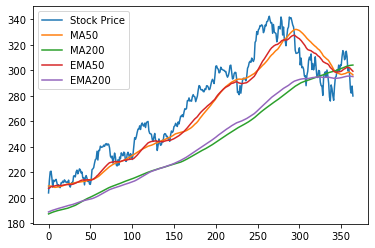

In [17]:
#Plotting the price action with the MAs and the EMAs

plt.plot(close_price[-365:], label="Stock Price")

plt.plot(MA50[-365:], label="MA50")
plt.plot(MA200[-365:], label="MA200")

plt.plot(EMA50[-365:], label="EMA50")
plt.plot(EMA200[-365:], label="EMA200")

plt.legend()

### Volume

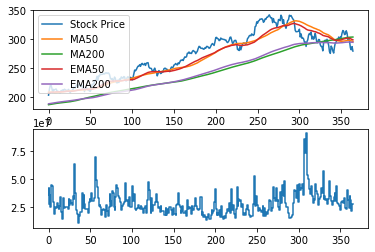

In [18]:
#Plotting the price action with the MAs, the EMAs and the Volume

plt.subplot(2,1,1)

plt.plot(close_price[-365:], label="Stock Price")

plt.plot(MA50[-365:], label="MA50")
plt.plot(MA200[-365:], label="MA200")

plt.plot(EMA50[-365:], label="EMA50")
plt.plot(EMA200[-365:], label="EMA200")

plt.legend()


plt.subplot(2,1,2)

plt.step(np.linspace(0, 365, 365), volume[-365:], drawstyle='steps-mid')

### RSI

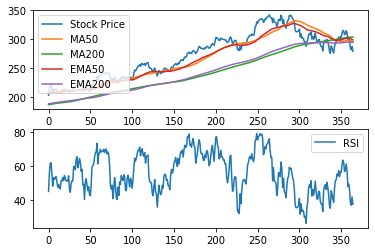

In [19]:
#Plotting the price action with the MAs, the EMAs and the RSI

plt.subplot(2,1,1)

plt.plot(close_price[-365:], label="Stock Price")

plt.plot(MA50[-365:], label="MA50")
plt.plot(MA200[-365:], label="MA200")

plt.plot(EMA50[-365:], label="EMA50")
plt.plot(EMA200[-365:], label="EMA200")

plt.legend()


plt.subplot(2,1,2)

plt.plot(RSI14[-365:], label="RSI")

plt.legend()

### Stochastic RSI

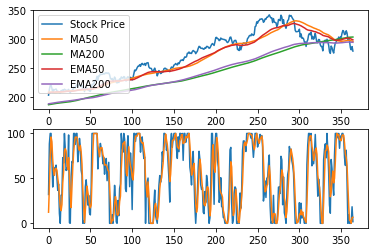

In [20]:
#Plotting the price action with the MAs, the EMAs and the Stochastic RSI

plt.subplot(2,1,1)

plt.plot(close_price[-365:], label="Stock Price")

plt.plot(MA50[-365:], label="MA50")
plt.plot(MA200[-365:], label="MA200")

plt.plot(EMA50[-365:], label="EMA50")
plt.plot(EMA200[-365:], label="EMA200")

plt.legend()


plt.subplot(2,1,2)

plt.plot(STOCH_K[-365:])
plt.plot(STOCH_D[-365:])

### MACD

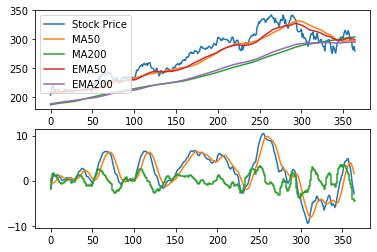

In [21]:
#Plotting the price action with the MAs, the EMAs and the MACD

plt.subplot(2,1,1)

plt.plot(close_price[-365:], label="Stock Price")

plt.plot(MA50[-365:], label="MA50")
plt.plot(MA200[-365:], label="MA200")

plt.plot(EMA50[-365:], label="EMA50")
plt.plot(EMA200[-365:], label="EMA200")

plt.legend()


plt.subplot(2,1,2)

plt.plot(MACD_VALUE[-365:])
plt.plot(SIG_LINE[-365:])
plt.step(np.linspace(0, 365, 365), MACD_HIST[-365:], drawstyle='steps-mid')

### Bollinger Bands

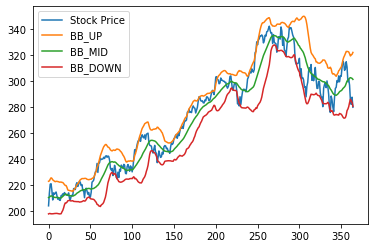

In [22]:
#Plotting the price action with the MAs, the EMAs and the Bollinger Bands

plt.plot(close_price[-365:], label="Stock Price")

plt.plot(BB_UP[-365:], label="BB_UP")
plt.plot(BB_MID[-365:], label="BB_MID")
plt.plot(BB_DOWN[-365:], label="BB_DOWN")

plt.legend()

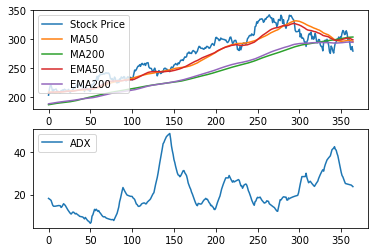

In [23]:
#Plotting the price action with the MAs, the EMAs and the ADX

plt.subplot(2,1,1)

plt.plot(close_price[-365:], label="Stock Price")

plt.plot(MA50[-365:], label="MA50")
plt.plot(MA200[-365:], label="MA200")

plt.plot(EMA50[-365:], label="EMA50")
plt.plot(EMA200[-365:], label="EMA200")

plt.legend()


plt.subplot(2,1,2)

plt.plot(ADX14[-365:], label="ADX")

plt.legend()

---

## CREATING THE OUTPUT FILE

In [24]:
#Creating the final dataset
Data_Stock = hist.drop(columns=['Dividends', 'Stock Splits'])
Data_Stock

,Open,High,Low,Close,Volume
Date,,,,,
1986-03-13,0.055783,0.063987,0.055783,0.061252,1031788800
1986-03-14,0.061252,0.064533,0.061252,0.063439,308160000
1986-03-17,0.063439,0.065080,0.063439,0.064533,133171200
1986-03-18,0.064533,0.065080,0.062345,0.062892,67766400
1986-03-19,0.062892,0.063439,0.061252,0.061799,47894400
...,...,...,...,...,...
2022-04-08,300.440002,301.119995,296.279999,296.970001,24347400
2022-04-11,291.790009,292.609985,285.000000,285.260010,34569300
2022-04-12,289.239990,290.739990,280.489990,282.059998,30966700


In [25]:
#Calculating if price goes up or down in the intervals
CHANGE = np.array([])

for i in range(0,len(close_price)-1):
    
    if close_price[i]<close_price[i+1]:
        CHANGE = np.append(CHANGE, "Up")
        
    elif close_price[i]>close_price[i+1]:
        CHANGE = np.append(CHANGE, "Down")
        
    else:
        CHANGE = np.append(CHANGE, "Equal")
        
CHANGE = np.append(CHANGE, "NaN")

In [26]:
#Including the calculated indicators in the file
Data_Stock["MA 50"] = MA50
Data_Stock["EMA 50"] = EMA50
Data_Stock["MA 200"] = MA200
Data_Stock["EMA 200"] = EMA200
Data_Stock["RSI 14"] = RSI14
Data_Stock["STOCH K"] = STOCH_K
Data_Stock["STOCH D"] = STOCH_D
Data_Stock["MACD VALUE"] = MACD_VALUE
Data_Stock["SIG LINE"] = SIG_LINE
Data_Stock["MACD HIST"] = MACD_HIST
Data_Stock["BB UP"] = BB_UP
Data_Stock["BB MID"] = BB_MID
Data_Stock["BB DOWN"] = BB_DOWN
Data_Stock["ADX"] = ADX14
Data_Stock["PRICE_CHANGE"] = CHANGE

Data_Stock

,Open,High,Low,Close,Volume,MA 50,EMA 50,MA 200,EMA 200,RSI 14,STOCH K,STOCH D,MACD VALUE,SIG LINE,MACD HIST,BB UP,BB MID,BB DOWN,ADX,PRICE_CHANGE
Date,,,,,,,,,,,,,,,,,,,,
1986-03-13,0.055783,0.063987,0.055783,0.061252,1031788800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Up
1986-03-14,0.061252,0.064533,0.061252,0.063439,308160000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Up
1986-03-17,0.063439,0.065080,0.063439,0.064533,133171200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Down
1986-03-18,0.064533,0.065080,0.062345,0.062892,67766400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Down
1986-03-19,0.062892,0.063439,0.061252,0.061799,47894400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Down
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-08,300.440002,301.119995,296.279999,296.970001,24347400,298.445648,301.971181,303.772665,295.482763,46.180919,0.000000,3.122670,2.292052,3.956223,-1.664171,321.114707,302.275500,283.436294,24.652421,Down
2022-04-11,291.790009,292.609985,285.000000,285.260010,34569300,297.998370,301.315840,303.881537,295.381044,38.825869,0.000000,3.122670,0.621366,3.629642,-3.008276,319.406276,302.716501,286.026726,24.556318,Down
2022-04-12,289.239990,290.739990,280.489990,282.059998,30966700,297.432803,300.560709,303.956015,295.248496,37.087544,0.000000,0.000000,-0.949929,3.050548,-4.000478,320.214874,302.462001,284.709128,24.467079,Up


In [27]:
#Remove the NaN values from the dataset
Data_Stock = Data_Stock.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
Data_Stock.head(10)

,Open,High,Low,Close,Volume,MA 50,EMA 50,MA 200,EMA 200,RSI 14,STOCH K,STOCH D,MACD VALUE,SIG LINE,MACD HIST,BB UP,BB MID,BB DOWN,ADX,PRICE_CHANGE
Date,,,,,,,,,,,,,,,,,,,,
1986-12-24,0.108284,0.108284,0.107738,0.108011,7027200,0.096329,0.096265,0.073464,0.073464,63.017860,75.426851,71.448910,0.002798,0.003105,-0.000307,0.110899,0.106070,0.101240,19.667614,Down
1986-12-26,0.108011,0.108831,0.107738,0.107738,3715200,0.096953,0.096715,0.073696,0.073805,62.201195,77.948657,75.881280,0.002757,0.002917,-0.000160,0.110397,0.105933,0.101468,20.032558,Down
1986-12-29,0.107738,0.108831,0.103363,0.103363,41702400,0.097489,0.096975,0.073896,0.074099,50.847206,3.190589,52.188699,0.002345,0.002761,-0.000416,0.110050,0.105659,0.101269,20.371421,Up
1986-12-30,0.103363,0.105003,0.102268,0.104457,25401600,0.098003,0.097269,0.074096,0.074401,53.149674,18.350732,33.163326,0.002082,0.002631,-0.000549,0.109946,0.105550,0.101155,20.686080,Up
1986-12-31,0.104456,0.107191,0.104456,0.105550,23356800,0.098528,0.097594,0.074309,0.074711,55.399458,33.163981,18.235101,0.001940,0.002524,-0.000584,0.109799,0.105468,0.101137,21.637142,Down
1987-01-02,0.105550,0.106644,0.103910,0.104457,12643200,0.098966,0.097863,0.074522,0.075007,52.675374,17.216827,22.910513,0.001719,0.002418,-0.000699,0.109704,0.105372,0.101041,22.520272,Up
1987-01-05,0.104457,0.111566,0.103910,0.110472,48499200,0.099523,0.098357,0.074774,0.075360,63.350154,96.683404,49.021404,0.002007,0.002347,-0.000340,0.110281,0.105509,0.100737,21.020494,Up
1987-01-06,0.110472,0.112659,0.109925,0.112113,40032000,0.100114,0.098897,0.075042,0.075726,65.627387,100.000000,71.300077,0.002340,0.002308,0.000032,0.111294,0.105755,0.100216,21.329096,Up
1987-01-07,0.112112,0.118129,0.112112,0.118129,60998400,0.100836,0.099651,0.075348,0.076148,72.399703,100.000000,98.894468,0.003054,0.002338,0.000716,0.114092,0.106357,0.098622,19.901460,Up


---

## DATASET EXPLORATION

In [28]:
print('The shape of the data is', Data_Stock.shape)    #Number of Rows and Columns

print(Data_Stock.describe(include=None))  #Looking at only the Intention of shoppers and if it's a weekend

#Review of frequency when a Purchase is completed when other parameters occur
CloseMA_freq = Data_Stock[['MA 50','PRICE_CHANGE']]
print(CloseMA_freq.value_counts(dropna=False,sort=True))

#Review of frequency when a Purchase is completed when other parameters occur
CloseEMA_freq = Data_Stock[['EMA 50','PRICE_CHANGE']]
print(CloseEMA_freq.value_counts(dropna=False,sort=True))

#Review of frequency when a Purchase is completed when other parameters occur
CloseRSI_freq = Data_Stock[['RSI 14','PRICE_CHANGE']]
print(CloseRSI_freq.value_counts(dropna=False,sort=True))

#Review of frequency when a Purchase is completed when other parameters occur
CloseSTOCH_freq = Data_Stock[['STOCH K','PRICE_CHANGE']]
print(CloseSTOCH_freq.value_counts(dropna=False,sort=True))

#Review of frequency when a Purchase is completed when other parameters occur
CloseADX_freq = Data_Stock[['ADX','PRICE_CHANGE']]
print(CloseADX_freq.value_counts(dropna=False,sort=True))

The shape of the data is (8899, 20)
              Open         High          Low        Close        Volume  \
count  8899.000000  8899.000000  8899.000000  8899.000000  8.899000e+03   
mean     37.490233    37.874520    37.091737    37.498519  5.919517e+07   
std      61.313493    61.901276    60.673509    61.322979  3.685821e+07   
min       0.103363     0.105003     0.102268     0.103363  3.705600e+06   
25%       3.602921     3.652141     3.553701     3.602920  3.527205e+07   
50%      19.191839    19.391915    19.006764    19.183159  5.236290e+07   
75%      29.837301    30.164040    29.382347    29.837300  7.294805e+07   
max     343.908878   348.948476   341.493913   342.402008  7.886880e+08   

             MA 50       EMA 50       MA 200      EMA 200       RSI 14  \
count  8899.000000  8899.000000  8899.000000  8899.000000  8899.000000   
mean     36.681975    36.674884    34.067868    34.200709    53.998705   
std      59.745148    59.674730    53.963930    54.227916    11.70

In [29]:
# Percentage chance on average over the whole dataset to go up or down (PRELIMINARY REVIEW)
PriceCH = Data_Stock[['PRICE_CHANGE']]
PriceCH_freq = PriceCH.value_counts(dropna=False,sort=True, ascending=True)
print(PriceCH_freq)
Percent_UP = (PriceCH_freq.iloc[3] / len(PriceCH))*100
Percent_Equal = (PriceCH_freq.iloc[1] / len(PriceCH))*100

print('The Probability, on average over the whole dataset, for the Stock(s) to be Up is', round(Percent_UP),'%')
print('The Probability, on average over the whole dataset, for the Stock(s) to be Equal is', round(Percent_Equal),'%')

PRICE_CHANGE
NaN                1
Equal            179
Down            4211
Up              4508
dtype: int64
The Probability, on average over the whole dataset, for the Stock(s) to be Up is 51 %
The Probability, on average over the whole dataset, for the Stock(s) to be Equal is 2 %


The linear correlating relationship of the Close and EMA is            Close    EMA 50
Close   1.000000  0.998633
EMA 50  0.998633  1.000000
The linear correlating relationship of the ADX and MACD is                 ADX  MACD HIST
ADX        1.000000   0.018227
MACD HIST  0.018227   1.000000
The linear correlating relationship of the BB Mid and SIG LINE is             BB MID  SIG LINE
BB MID    1.000000  0.428169
SIG LINE  0.428169  1.000000
             Close          ADX
count  8899.000000  8899.000000
mean     37.498519    19.772967
std      61.322979     8.775702
min       0.103363     5.093303
25%       3.602920    13.385995
50%      19.183159    17.965455
75%      29.837300    24.069196
max     342.402008    64.548844
          SIG LINE    MACD HIST
count  8899.000000  8899.000000
mean      0.235414    -0.000087
std       1.107017     0.434275
min      -8.153908    -4.499855
25%      -0.036500    -0.056916
50%       0.028816     0.000139
75%       0.320940     0.059676
max       

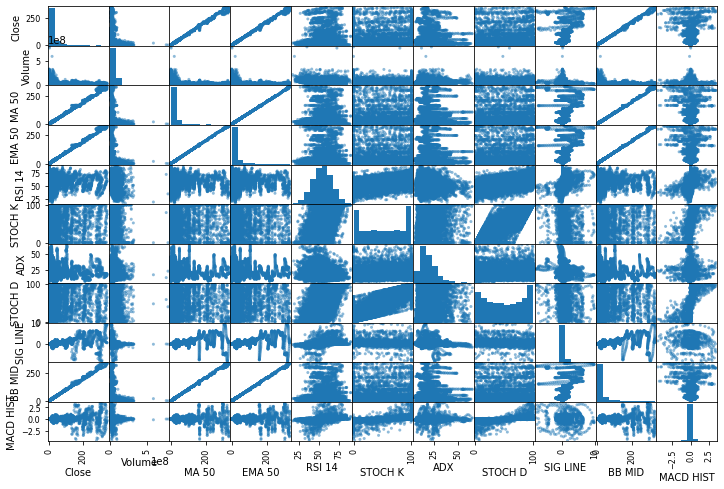

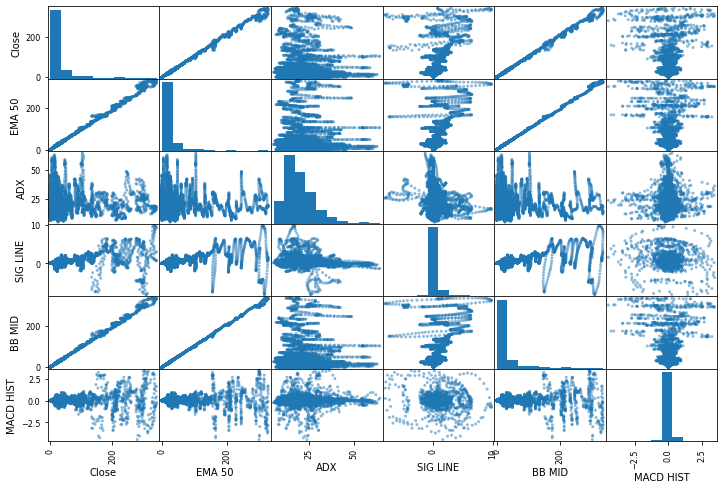

In [30]:
from pandas.plotting import scatter_matrix
scatter_matrix(Data_Stock[['Close','Volume','MA 50','EMA 50','RSI 14','STOCH K', 'ADX', 'STOCH D', 'SIG LINE','BB MID', 'MACD HIST']], figsize=(12, 8))
scatter_matrix(Data_Stock[['Close','EMA 50','ADX','SIG LINE','BB MID', 'MACD HIST']], figsize=(12, 8)) #Remove some of less interesting trends

#Let us also now look at the covariance of the two datasets
corr_matrix = Data_Stock[['Close','EMA 50']].corr()
print('The linear correlating relationship of the Close and EMA is', corr_matrix)
corr_matrix_2 = Data_Stock[['ADX','MACD HIST']].corr()
print('The linear correlating relationship of the ADX and MACD is', corr_matrix_2)
corr_matrix_3 = Data_Stock[['BB MID','SIG LINE']].corr()
print('The linear correlating relationship of the BB Mid and SIG LINE is', corr_matrix_3)

#Two Interesting relationship for Close is:
print(Data_Stock[['Close', 'ADX']].describe())
print(Data_Stock[['SIG LINE', 'MACD HIST']].describe())

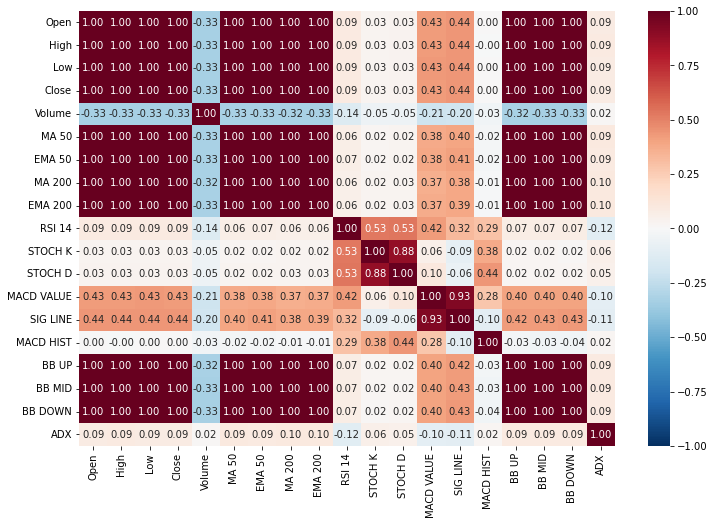

In [31]:
from seaborn import heatmap
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,8))
ax = heatmap(Data_Stock.corr(), fmt=".2f", annot=True, ax=ax, cmap="RdBu_r", vmin=-1, vmax=1)
plt.savefig = ('corr.pdf')

<AxesSubplot:>

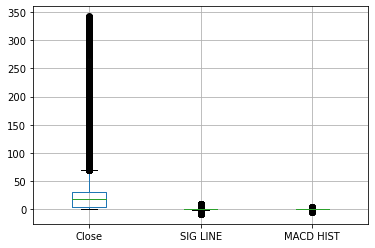

In [32]:
#Boxplots
Data_Stock[['Close', 'SIG LINE','MACD HIST']].boxplot()

<AxesSubplot:>

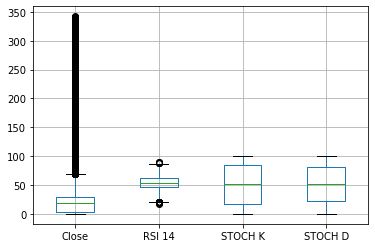

In [33]:
#More Boxplots
Data_Stock[['Close', 'RSI 14','STOCH K', 'STOCH D']].boxplot()

<AxesSubplot:>

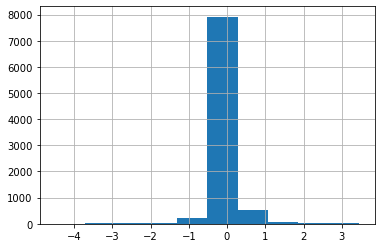

In [34]:
#Histograms
Data_Stock['MACD HIST'].hist()

<AxesSubplot:>

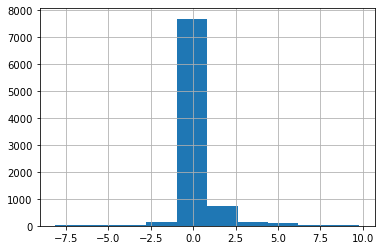

In [35]:
#More Histograms
Data_Stock['SIG LINE'].hist()

## SAVING AND LOADING CSV FILES - TESTING PURPOSES

In [36]:
#Data_Stock.to_csv(r'Stock_Data_1d.csv')

In [37]:
test_input = pd.read_csv('Stock_Data_1d.csv',index_col=0)

In [38]:
test_input

,Open,High,Low,Close,Volume,MA 50,EMA 50,MA 200,EMA 200,RSI 14,STOCH K,STOCH D,MACD VALUE,SIG LINE,MACD HIST,BB UP,BB MID,BB DOWN,ADX,PRICE_CHANGE
Date,,,,,,,,,,,,,,,,,,,,
1986-03-13,0.055783,0.063987,0.055783,0.061252,1031788800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Up
1986-03-14,0.061252,0.064533,0.061252,0.063439,308160000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Up
1986-03-17,0.063439,0.065080,0.063439,0.064533,133171200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Down
1986-03-18,0.064533,0.065080,0.062345,0.062892,67766400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Down
1986-03-19,0.062892,0.063439,0.061252,0.061799,47894400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Down
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-06,305.190002,307.000000,296.709991,299.500000,40110400,298.385229,302.208180,303.425367,295.408497,47.996855,0.000000,42.461359,3.861674,3.784516,0.077158,322.839254,300.641501,278.443748,24.867374,Up
2022-04-07,296.660004,303.649994,296.350006,301.369995,31411200,298.490674,302.175310,303.613546,295.467816,49.449322,9.368011,18.462356,3.198827,3.974424,-0.775597,322.526632,301.430501,280.334370,24.755917,Down
2022-04-08,300.440002,301.119995,296.279999,296.970001,24347400,298.445648,301.971181,303.772665,295.482763,46.180919,0.000000,3.122670,2.292052,3.956223,-1.664171,321.114707,302.275500,283.436294,24.652421,Down


In [39]:
# Percentage chance on average over the whole dataset to go up or down (PRELIMINARY REVIEW) - VERIFY SAME AS BEFORE
PriceCH_test = test_input[['PRICE_CHANGE']]
PriceCH_freq_test = PriceCH_test.value_counts(dropna=False,sort=True, ascending=True)
print(PriceCH_freq_test)
Percent_UP_test = (PriceCH_freq_test.iloc[3] / len(PriceCH_test))*100
Percent_Equal_test = (PriceCH_freq_test.iloc[1] / len(PriceCH_test))*100

print('The Probability, on average over the whole dataset, for the Stock(s) to be Up is', round(Percent_UP_test),'%')
print('The Probability, on average over the whole dataset, for the Stock(s) to be Equal is', round(Percent_Equal_test),'%')

PRICE_CHANGE
NaN                1
Equal            211
Down            4286
Up              4598
dtype: int64
The Probability, on average over the whole dataset, for the Stock(s) to be Up is 51 %
The Probability, on average over the whole dataset, for the Stock(s) to be Equal is 2 %


---

## DATA PREPROCESSING

In [40]:
# #Including the calculated indicators in the file
# Data_Stock["MA 50"] = MA50 / Data_Stock["Close"]
# Data_Stock["EMA 50"] = EMA50 / Data_Stock["Close"]
# Data_Stock["MA 200"] = MA200 / Data_Stock["Close"]
# Data_Stock["EMA 200"] = EMA200 / Data_Stock["Close"]
# Data_Stock["RSI 14"] = RSI14
# Data_Stock["STOCH K"] = STOCH_K
# Data_Stock["STOCH D"] = STOCH_D
# Data_Stock["MACD VALUE"] = MACD_VALUE
# Data_Stock["SIG LINE"] = SIG_LINE
# Data_Stock["MACD HIST"] = MACD_HIST
# Data_Stock["BB UP"] = BB_UP / Data_Stock["Close"]
# Data_Stock["BB MID"] = BB_MID / Data_Stock["Close"]
# Data_Stock["BB DOWN"] = BB_DOWN / Data_Stock["Close"]
# Data_Stock["ADX"] = ADX14
# Data_Stock["PRICE_CHANGE"] = CHANGE

# Data_Stock

In [41]:
#Label Encoding - could also use OneHotEncoder but think this is easier here

from sklearn import preprocessing
enc = preprocessing.LabelEncoder()
Price_change_2 = Data_Stock.iloc[:,-1:]
Price_change_2 = Price_change_2.apply(enc.fit_transform, axis=0)
Price_change_2.head(10)

,PRICE_CHANGE
Date,
1986-12-24,0
1986-12-26,0
1986-12-29,3
1986-12-30,3
1986-12-31,0
1987-01-02,3
1987-01-05,3
1987-01-06,3
1987-01-07,3


## Looking back at the previous .head of the dataset this looks to be working. 
Down = 0; 
Up = 3

In [42]:
#Add on end of the inital dataset
Data_Stock = Data_Stock.iloc[: , :-1]
Data_Stock['PRICE_CHANGE'] = Price_change_2
Data_Stock.head(10)

,Open,High,Low,Close,Volume,MA 50,EMA 50,MA 200,EMA 200,RSI 14,STOCH K,STOCH D,MACD VALUE,SIG LINE,MACD HIST,BB UP,BB MID,BB DOWN,ADX,PRICE_CHANGE
Date,,,,,,,,,,,,,,,,,,,,
1986-12-24,0.108284,0.108284,0.107738,0.108011,7027200,0.096329,0.096265,0.073464,0.073464,63.017860,75.426851,71.448910,0.002798,0.003105,-0.000307,0.110899,0.106070,0.101240,19.667614,0
1986-12-26,0.108011,0.108831,0.107738,0.107738,3715200,0.096953,0.096715,0.073696,0.073805,62.201195,77.948657,75.881280,0.002757,0.002917,-0.000160,0.110397,0.105933,0.101468,20.032558,0
1986-12-29,0.107738,0.108831,0.103363,0.103363,41702400,0.097489,0.096975,0.073896,0.074099,50.847206,3.190589,52.188699,0.002345,0.002761,-0.000416,0.110050,0.105659,0.101269,20.371421,3
1986-12-30,0.103363,0.105003,0.102268,0.104457,25401600,0.098003,0.097269,0.074096,0.074401,53.149674,18.350732,33.163326,0.002082,0.002631,-0.000549,0.109946,0.105550,0.101155,20.686080,3
1986-12-31,0.104456,0.107191,0.104456,0.105550,23356800,0.098528,0.097594,0.074309,0.074711,55.399458,33.163981,18.235101,0.001940,0.002524,-0.000584,0.109799,0.105468,0.101137,21.637142,0
1987-01-02,0.105550,0.106644,0.103910,0.104457,12643200,0.098966,0.097863,0.074522,0.075007,52.675374,17.216827,22.910513,0.001719,0.002418,-0.000699,0.109704,0.105372,0.101041,22.520272,3
1987-01-05,0.104457,0.111566,0.103910,0.110472,48499200,0.099523,0.098357,0.074774,0.075360,63.350154,96.683404,49.021404,0.002007,0.002347,-0.000340,0.110281,0.105509,0.100737,21.020494,3
1987-01-06,0.110472,0.112659,0.109925,0.112113,40032000,0.100114,0.098897,0.075042,0.075726,65.627387,100.000000,71.300077,0.002340,0.002308,0.000032,0.111294,0.105755,0.100216,21.329096,3
1987-01-07,0.112112,0.118129,0.112112,0.118129,60998400,0.100836,0.099651,0.075348,0.076148,72.399703,100.000000,98.894468,0.003054,0.002338,0.000716,0.114092,0.106357,0.098622,19.901460,3


In [43]:
# split into trainind and test datasets - Borrowed from Lab12 UPDATE IF NEEDED
ratio = round(0.8*Data_Stock.shape[0])
train = Data_Stock[:ratio]
test = Data_Stock[ratio:]
print('training data size: ', train.shape, '\n    testing data size: ', test.shape)

training data size:  (7119, 20) 
    testing data size:  (1780, 20)


In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
minMax_scale = MaxAbsScaler()   # to default range [0, 1]
train = minMax_scale.fit_transform(train)
test = minMax_scale.fit_transform(test)

In [45]:
train, test

(array([[0.0024919 , 0.00247646, 0.00249688, ..., 0.00242968, 0.31174856,
         0.        ],
        [0.00248561, 0.00248897, 0.00249688, ..., 0.00243516, 0.31753324,
         0.        ],
        [0.00247931, 0.00248897, 0.00239549, ..., 0.00243038, 0.32290451,
         1.        ],
        ...,
        [0.86106075, 0.86240979, 0.86634192, ..., 0.86805098, 0.19674592,
         1.        ],
        [0.86717352, 0.87030705, 0.87188237, ..., 0.86816005, 0.18637586,
         0.        ],
        [0.87369372, 0.87334455, 0.87783313, ..., 0.86892028, 0.17825603,
         1.        ]]),
 array([[0.11013813, 0.10953705, 0.11083922, ..., 0.11050764, 0.16556279,
         0.        ],
        [0.11049859, 0.10892812, 0.10744277, ..., 0.11025435, 0.15752211,
         0.        ],
        [0.1061219 , 0.10557882, 0.10609454, ..., 0.1100123 , 0.15005576,
         0.        ],
        ...,
        [0.84103671, 0.83318888, 0.82136161, ..., 0.86802284, 0.37904752,
         1.        ],
        [0.8

In [46]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, test_X.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(train_X.shape, test_X.shape)

(7119, 19) (1780, 19)
(7119, 1, 19) (7119,) (1780, 1, 19) (1780,)
(7119, 1, 19) (1780, 1, 19)


## First Classification Method: Define and train LSTM

In [47]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [48]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
99/99 - 2s - loss: 0.5031 - val_loss: 0.5104 - 2s/epoch - 20ms/step
Epoch 2/50
99/99 - 0s - loss: 0.4986 - val_loss: 0.5061 - 181ms/epoch - 2ms/step
Epoch 3/50
99/99 - 0s - loss: 0.4955 - val_loss: 0.5079 - 207ms/epoch - 2ms/step
Epoch 4/50
99/99 - 0s - loss: 0.4939 - val_loss: 0.5095 - 211ms/epoch - 2ms/step
Epoch 5/50
99/99 - 0s - loss: 0.4928 - val_loss: 0.5083 - 178ms/epoch - 2ms/step
Epoch 6/50
99/99 - 0s - loss: 0.4922 - val_loss: 0.5063 - 158ms/epoch - 2ms/step
Epoch 7/50
99/99 - 0s - loss: 0.4920 - val_loss: 0.5053 - 165ms/epoch - 2ms/step
Epoch 8/50
99/99 - 0s - loss: 0.4919 - val_loss: 0.5054 - 209ms/epoch - 2ms/step
Epoch 9/50
99/99 - 0s - loss: 0.4916 - val_loss: 0.5047 - 182ms/epoch - 2ms/step
Epoch 10/50
99/99 - 0s - loss: 0.4915 - val_loss: 0.5043 - 188ms/epoch - 2ms/step
Epoch 11/50
99/99 - 0s - loss: 0.4914 - val_loss: 0.5029 - 173ms/epoch - 2ms/step
Epoch 12/50
99/99 - 0s - loss: 0.4914 - val_loss: 0.5015 - 275ms/epoch - 3ms/step
Epoch 13/50
99/99 - 0s - lo

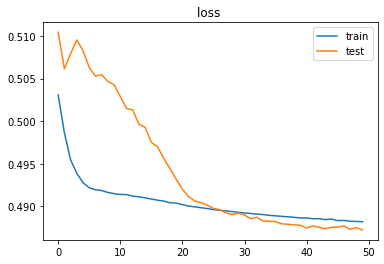

In [49]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('loss ')
plt.legend()
plt.show()

In [50]:
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error

## Need to come back and work on this again I think - in the lab he uses inverse values

In [51]:
yhat = model.predict(test_X)

yhat = concatenate((yhat, yhat), axis=1)
yhat = yhat[:,0]

test_y = test_y.reshape((len(test_y), 1))
y = concatenate((test_y, test_y), axis=1)
y = y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.537


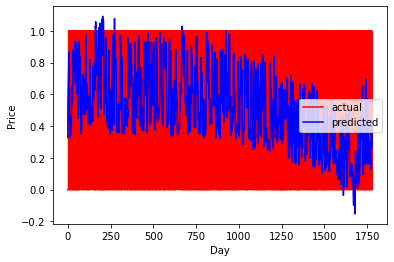

In [52]:
plt.plot(y, color = 'red', label = 'actual')
plt.plot(yhat, color = 'blue', label = 'predicted')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

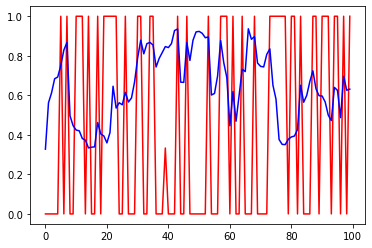

In [53]:
plt.plot(y[:100], color = 'red', label = 'actual')
plt.plot(yhat[:100], color = 'blue', label = 'predicted')

## Obviously this needs more work!

## -------------------------------------------------------------------------------------------------

## Second Classification Method: SVM - Adapted from Adam's Previous Code

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

#DiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

#SVMs
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from mpl_toolkits import mplot3d

In [55]:
print(Price_change_2)

            PRICE_CHANGE
Date                    
1986-12-24             0
1986-12-26             0
1986-12-29             3
1986-12-30             3
1986-12-31             0
...                  ...
2022-04-08             0
2022-04-11             0
2022-04-12             3
2022-04-13             0
2022-04-14             2

[8899 rows x 1 columns]


In [56]:
Data_Stock = Data_Stock.iloc[: , :-1]   #Remove Price_change from the dataset 
#Data_Stock = Data_Stock['Close']

In [57]:
X_train, X_test, y_train, y_test=train_test_split(Data_Stock,Price_change_2,train_size=0.0005) # May need to change this train_size number in future

print(X_train.shape, y_train.shape)
model=SVC(kernel="linear",C=1000000)
svmfit=model.fit(X_train,y_train)

y_preds_linear=svmfit.predict(X_test)

cm_svm1000=metrics.confusion_matrix(y_preds,y_test)
cm_svm_linear=metrics.confusion_matrix(y_preds_linear,y_test)

(4,) (4, 1)


ValueError: Expected 2D array, got 1D array instead:
array=[ 4.03113651  2.16076875  0.25211719 20.66265297].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
plt.figure(figsize=(6,6))
sns.heatmap(cm_svm_linear,annot=True,fmt="d",linewidths=.5,square=True,cmap="summer")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
all_sample_title=("SVM: Linear Kernel training_set=2500")
plt.title(all_sample_title,size=15)
#plt.savefig('fig12.png')

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import(average_precision_score)
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
y_pred = svc.predict(X_test)
print('The accuracy of the set of labels for the dataset using SVM is',(accuracy_score(y_test, y_pred)*100),'%')

In [ ]:
print('The recall score for the dataset using SVM is',(recall_score(y_test,y_pred)*100),'%')
print('The precision percent value for the dataset using SVM is',(precision_score(y_test,y_pred)*100),'%')
print('The precision percent value for the dataset using SVM is',(average_precision_score(y_test,y_pred)*100),'%')
print('The precision percent value for the dataset using SVM is',(f1_score(y_test,y_pred)*100),'%')